# Lab 7: Unsupervised Learning
Machine Learning 2019/2020 <br>
Ruben Wiersma and Gosia Migut

**WHAT** This nonmandatory lab consists of several programming and insight exercises/questions on unsupervised learning with k-means clustering and PCA. 

**WHY** The exercises are meant to familiarize yourself with the basic concepts of unsupervised learning.

**HOW** Follow the exercises in this notebook either on your own or with a friend. There is quite a bit of theory and explanation in these notebooks. If you want to skip right to questions and exercises, find the $\rightarrow$ symbol. Use [Mattermost][1] to discuss questions with your peers. For additional questions and feedback please consult the TA's during the lab session. 

[1]: https://mattermost.ewi.tudelft.nl/ml/channels/town-square
$\newcommand{\q}[1]{\rightarrow \textbf{Question #1}}$
$\newcommand{\ex}[1]{\rightarrow \textbf{Exercise #1}}$

## Learning without examples

As a child you probably taught yourself how to separate building blocks from each other. Even without someone _telling you_ which shape was which, you could decide which shapes belonged to each other to make separate heaps of cubes, cylinders, and pyramids. You performed a form of _unsupervised learning_: clustering.

In the previous part, you applied data dimensionality techniques. Now will apply these techniques to a new dataset and perform k-means clustering on the retrieved features.

### Structure

This assignment consists of two parts:
- In [Part 1](part1_dimensionalityreduction.ipynb), you will get familiar with dimensionality reduction using PCA.
- In [Part 2](part2_clustering.ipynb), you will apply your PCA algorithm and practice with k-Means clustering.

## Part 1a: Preparing the data

In this assignment, you will work with the TIDIGITS dataset. This dataset was created by Texas Instruments (hence, TI) and is a set of voice recordings of digits. You can go ahead and give the audio files a listen in the data folder: `data/tidigits/...`.

Before we can use any clustering algorithms on these data, we need a way to describe our audio files in a way that a computer can understand. An audio file is read as an array, where each value in the array is the amplitude of the audio at a the corresponding time. We refer to these data as _raw_ waveforms. It's infeasible to use the raw data for clustering, therefore we need to extract a limited number of _features_ to describe each audiofile: __feature extraction__.

We will extract _MFCC_ features. To extract these, we split the audio file in frames of 25ms each. Next, we apply a number of complicated operations to retrieve $13$ features per frame. If a file is split in, for example, 100 frames, this means we have $13 * 100 = 1300$ features! To bring this number down, we sample  5  frames from regular intervals (the size of the interval is dependent on the length of the audio file) and flatten this to an array of  5∗13=65  features (this number is thus independent of the length of the audio file).

$\ex{1a.1}$ Using pip (Python's package manager), install `python_speech_features` and `soundfile`:
```
$ pip install python_speech_features SoundFile
```
If all this fails, we have a backup dataset for you down below.

$\ex{1a.2}$ Run the code below to extract MFCC features for the 150 files provided. This will give you a dataset with 50 'one' audiofiles, 50 'two' audiofiles and 50 'three' audiofiles.

In [1]:
import python_speech_features as features
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

def extract_mfcc(sound, sample = 5):
    # Read in the flac file
    data, samplerate = sf.read(sound)
    
    # Extract MFCC features.
    # For each frame (25ms segment of audio) in the file, we get 13 MFCC features,
    # giving us a [n x 5] matrix of features
    mfcc_feat = np.asarray(features.mfcc(data,samplerate), dtype='float32')
    
    # We sample 5 frames and flatten the feature vectors into one large 'supervector'.
    idx = np.floor(np.linspace(0, mfcc_feat.shape[0] - 1, sample)).astype(int)
    mfcc_sampled = mfcc_feat[idx]
    mfcc_feat_vector = mfcc_sampled.flatten()
    
    return mfcc_feat_vector

# Read audiofiles and extract MFCC feature vectors
one = []
for i in range(50):
    feat = extract_mfcc("data/tidigits/1/{:d}.flac".format(i))
    one.append(feat)
two = []
for i in range(50):
    feat = extract_mfcc("data/tidigits/2/{:d}.flac".format(i))
    two.append(feat)
three = []
for i in range(50):
    feat = extract_mfcc("data/tidigits/3/{:d}.flac".format(i))
    three.append(feat)

# Concatenate into one large dataset
X_train = np.concatenate((one, two, three))
ones = np.ones(50)
y_train = np.concatenate((ones, ones * 2, ones * 3)).astype(int)
np.savetxt("data/tidigits_features.txt", X_train)
np.savetxt("data/tidigits_targets.txt", y_train)

In [2]:
# Backup if you cannot load the MFCC code
X_train = np.loadtxt("data/tidigits_features.txt")
y_train = np.loadtxt("data/tidigits_targets.txt")

### Reducing the number of features

Now we have 150 data points (i.e., 150 audio files) and each data point consists of 65 features describing the audio file. Let's plot the the first two features.

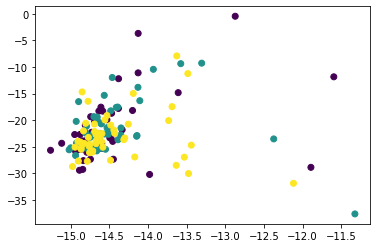

In [3]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)

Well... it seems like we can't cluster our points based on the first two features. There must be some combination of features that will allow us to cluster our points. If only there was a way to automatically find a combination of features that will allow us to cluster the data points, without supervision...

But wait! We do have such a technique: PCA. And you've just implemented it in the previous part. Let's go ahead and apply PCA to find the four most descriptive 'directions' in the data and project the features onto these directions.

This involves the following steps:
- First compute the covariance matrix of the dataset
- Compute the first four eigenvectors of the covariance matrix
- Project the feature vector for point in the original dataset on these four eigenvectors
    * Projecting a vector onto another vector is done with the dot product
   
This should give us four features for each point that describe our audio well. We are plotting just two of these features, as this can be easily visualised, but will need four features to accurately cluster all points.

$\ex{1a.3}$ Complete the following code to reduce the number of features with PCA. Plot your results.

__Hint__ you can use your own implementation of PCA, or use PCA from Scipy's or Numpy's linear algebra library.

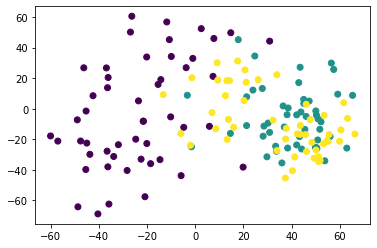

In [4]:
# First compute the covariance matrix of the dataset
import numpy as np
import numpy.linalg as la
# STUDENT
def covariance(data):
    """
    This function computes the computes the covariance matrix of a given `data`.
    :param data: the starting data
    :return: the covariance matrix 
    """
    # -------------------------------Student ---------------------------------------
    mean = np.mean(data,0)
    diff = np.subtract(data,mean)
    matrix = (1/np.shape(data)[0])*(np.matmul(np.transpose(diff),diff))
    # -------------------------------end Student ---------------------------------------
    return matrix

matrix = covariance(X_train)
#print(np.shape(matrix))
# END STUDENT

# Next, retrieve the four eigenvectors of the covariance matrix
# CHALLENGE: you can use your own implementation of power iteration to find the eigenvectors.

# STUDENT


def power_iteration(matrix, n_vectors, e):
    """
    This function returns a list with `n_vectors` amount of eigenvectors (numpy vectors) based on the given square 
    `matrix` and the convergence parameter `e`.
    :param matrix: the square matrix
    :param n_vectors: the number of eigenvectors
    :param e: the convergence parameter
    :return: the list of eigenvectors found
    """
    assert (matrix.shape[0] == matrix.shape[1] & matrix.shape[1] >= n_vectors)

    eigen_vectors = list()
    # -------------------------------Student ---------------------------------------
    for i in range(n_vectors):    
        stop = np.ones((matrix.shape[0],1))
        v_k = np.ones((matrix.shape[0],1))
        while np.amin(stop) >= e:
            v_kplusone = np.matmul(matrix,v_k)/la.norm(np.matmul(matrix,v_k))
            stop = np.absolute(v_kplusone-v_k)
            v_k = v_kplusone

        principle_eigen =  v_kplusone
        eigen_vectors.append(principle_eigen)
        lamda = np.matmul(np.transpose(v_kplusone),np.matmul(matrix,v_kplusone))
        m_star = matrix - np.multiply(lamda,np.matmul(v_kplusone,np.transpose(v_kplusone)))
        matrix = m_star

    # -------------------------------end Student ---------------------------------------        
    return eigen_vectors


e = np.float_power(10,-5)
eigen_vectors = power_iteration(matrix,4, e)
#print(np.shape(eigen_vectors[0]))
# END STUDENT

# We project our points onto the eigenvectors using matrix multiplication
X_train_reduced = np.zeros((X_train.shape[0], 4))
for i in range(len(X_train)):
    X_train_reduced[i, :] = np.matmul(X_train[i, :].T, eigen_vectors).T
    
# And plot the points with the new data
plt.scatter(X_train_reduced[:, 0], X_train_reduced[:, 1], c=y_train)
plt.show()

Looks like we have ourselves a dataset that we can start clustering!

__Important note__ We have now shown the labels for each point as the colour, but we will not be using the labels for training. You'll just use the labels to verify the clusters your are deriving from the data itself.

# Part 2: K-Means clustering

First, we will implement the (original) k-means clustering algorithm. This algorithm works as follows: we start with $k$ clusters and pick some random centre (mean) for each cluster. Next, we assign points to each cluster based on the distance to each centre and we update the centre to the mean of all points in the cluster. This is repeated until the centres stop moving.

Pointwise, the steps of the k-means clustering algorithm approach are as follows:
1. Initialize $k$ cluster centers at random locations.
2. Assign each point to a cluster.
3. Update the cluster centers.
4. Go to step 2 unless converged or a number of iterations have been done.

First, we create a `Cluster` class.

$\ex{1.1}$ Finish the method that calculates the centroid (other word for centre) of the cluster,
`Cluster.centroid`. The centroid is the mean vector of all feature vectors. This method will get called frequently, while the cluster (and thus the centroid) sometimes remains unchanged. To increase efficiency, store and reuse the cluster centroid until the cluster itself changes (i.e. points are added or removed), at which point a new centroid should be calculated.

__Hint__ use the changed flag to see if the centroid needs to be recomputed, or if the current value is still valid.

In [20]:
import numpy as np

# This Object is used to store the clusters. A Cluster object consists of a numpy 
# matrix containing all feature vectors in the cluster and the centroid of all the vectors.
# The object also contains a boolean for speedup purposes.
class Cluster(object):

    def __init__(self, array=np.matrix([])):
        self.changed = True
        self.data = np.matrix(array)
        self.cd = self.data
        #print(np.shape(self.data))
        
    def reset_cluster(self):
        self.data = np.array([])
    
    def is_changed(self):
        return self.changed
    
    def set_changed(self, changed):
        self.changed = changed
    
    def set_centroid(self, vector):
        self.cd = vector
    
    def append(self, other):
        # Set changed flag to true (the cluster has changed)
        self.set_changed(True)
        
        self.data = np.vstack((self.data, other))

    def centroid(self):
        #If the matrix consists of 1 vector, no need to compute centroid.
        if len(np.shape(self.data)) == 1:
            return self.data
        # Checking whether the cluster has changed since last computation (for speedup)
        if self.is_changed():
            N = len(self.data[:,0])
            x_sum = np.sum(self.data[:,0])
            y_sum = np.sum(self.data[:,1])
            self.cd = [[x_sum/N,y_sum/N]]
            #print(self.cd)
            #print(vector)
            ## Missing code here => implement yourself
# -------------------------------Student ---------------------------------------        
            
# -------------------------------end Student ---------------------------------------         
        # Set changed flag to false, untill it changes.
        self.set_changed(False)
        return self.cd
    
# Some small test cases the Cluster class
c = Cluster(np.array([[0, 1], [2, 0]]))
#print(c.centroid())
#print(np.shape(c.centroid()))
#print(np.shape(np.array([[1.0, 0.5]])))
# Verifies that the centroid is calculated correctly
np.testing.assert_array_equal(c.centroid(), np.array([[1.0, 0.5]]))

# Verifies that the centroid is calculated correctly after a new data point has been added.
c.append(np.array([1, 2]))
np.testing.assert_array_equal(c.centroid(), np.array([[1.0, 1.0]]))

Next, let's take a look at the data that we will be clustering. Note we plotted the data here as the algorithm will see it, thus without labels.

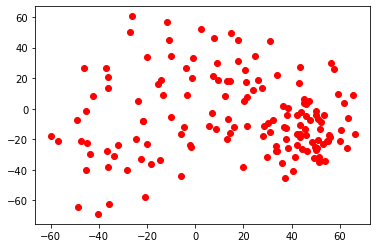

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
# This function can be used to load the given cluster data into a list of cluster objects
# It is also allowed to create your own function to load the data
def read_file(file):
    lines = [line.rstrip('\n') for line in open(file)]
    # init data structure
    points = []
    for line in lines:
        # Take FeatureVector from dataset
        elements = line.split(" ")
        p = [float(el) for el in elements]
        # Append FeatureVector to the list of clusters
        points.append(p)
    points = np.asarray(points)
    return points

# If the previous steps for feature extraction and reduction failed, you can use these data.
# Otherwise, we will use the data and features you extracted yourself!
# points = read_file("data/cluster.txt")
points = X_train_reduced
x = points[:, 0]
y = points[:, 1]
plt.scatter(x, y, c='r')
plt.show()

### Step 1

Now you will start implementing k-Means. Let's start at step 1: Initialize k cluster centers at random locations.

$\ex{1.2}$  Finish the `addInitPoints` function. This function selects a random point in the dataset, constructs a cluster around it and adds the cluster to the list of clusters.

In [ ]:
from random import sample

# This function selects random k points from the dataset , for each random point it initializes the cluster 
# and adds the cluster to the list of clusters.
def add_init_points(points, clusters, k):
# -------------------------------Student ---------------------------------------

# -------------------------------end Student ---------------------------------------
    return clusters

### Step 2

Now you will implement the update step. In the update process, we assign points to clusters based on their distance to each centroid.

$\ex{1.3}$ Implement the `distance` function. We will use Euclidean distance.

In [ ]:
def distance(p1, p2):
    # Euclidian distance between 2 points (in any space)
# -------------------------------Student ---------------------------------------

# -------------------------------end Student ---------------------------------------

# Verifies that the distance metric is correct
np.testing.assert_array_equal(distance(np.zeros([1, 2]), np.ones([1, 2])), np.sqrt(2))

$\ex{1.4}$ Implement the update step of the k-Means clustering algorithm. First, use `addInitPoint` if no clusters are present yet to initialize $k$ clusters. After this check, we perform an iteration of the k-Means clustering algorithm. This consists of the following steps: 
1. Calculate the centroids of each cluster and save them.
2. Then remove all points from all clusters.
3. Finally add each point to the closest cluster centroid (the centroids that you saved earlier).

__Hint__ You will want to save the cluster centroids, because otherwise the cluster centroids will change during step 3 because they will be recalculated.

In [ ]:
import sys

# This function updates the the kClusters list with a given amount of k clusters for 
# each feature vector from the clusters list
def update_k_means(points, clusters, k):
    # Reset Clusters   
    centroids = []
 
    # Add initial points
    # If add_clusters is true, initalise clusters with add_init_points
    # Then add the cluster centroids to the centroids list
    add_clusters = len(clusters) == 0
# 1-------------------------------Student ---------------------------------------   
    

    
# 1-------------------------------end Student --------------------------------------- 
    # Reset clusters from last iteration,
    # so the clustering can be performed with new centroids.
    for cluster in clusters:
        cluster.reset_cluster()
        
    clusters = [None for el in range(k)]
    for p in points:
    
    # Calculate the min distance to one of the centroids
# 2-------------------------------Student ---------------------------------------

# 2-------------------------------end Student ---------------------------------------
    # Add the data point to the cluster with min_distance to centroid
        if label >= 0:
            if clusters[label] is None:
                clusters[label] = Cluster(p)
            else:
                clusters[label].append(p)
         
    return clusters

### Step 3
$\ex{1.5a}$ Use the `plot_k_means_data` function to plot the clustered data (you might have to run your algorithm with a different random seed to get a proper clustering) and have it analyse the TIDIGITS dataset (or `data/cluster.txt`) with $k$ set to 3. Run the k-means clustering algorithm and verify that it is clustering the points as intended. Use `plot_k_means_data_update` to see the cluster updates at each iteration.


In [ ]:
import matplotlib.cm as cm
    
def plot_k_means_data( clusters, k, itr):
    colors = cm.brg(np.linspace(0,1,k))
    for (i,cl) in enumerate(colors):
        x = [[el[0,0]] for el in clusters[i].data]
        y = [[el[0,1]] for el in clusters[i].data] 
        plt.scatter(x, y, c=[cl])
        plt.scatter(clusters[i].centroid()[0,0], clusters[i].centroid()[0,1], c='black')
        plt.title("Clusters at update " + str(itr))
    plt.show()
    
def plot_k_means_data_update(clusters_prev, clusters, k):
    if(clusters_prev == []):
        return
    colors = cm.brg(np.linspace(0,1,k))
    for (i,cl) in enumerate(colors):
        
        x = [[el[0,0]] for el in clusters[i].data]
        y = [[el[0,1]] for el in clusters[i].data] 
        plt.scatter(x, y, c=[cl], marker = '*')

        plt.scatter(clusters[i].centroid()[0,0], clusters[i].centroid()[0,1], c='black')
        
        x_prev = [[el[0,0]] for el in clusters_prev[i].data]
        y_prev = [[el[0,1]] for el in clusters_prev[i].data]
        
        plt.scatter(x_prev, y_prev, c=[cl], alpha=0.2, s=100)
        
        plt.scatter(clusters_prev[i].centroid()[0,0], clusters_prev[i].centroid()[0,1], c='green')
        plt.legend(['New clusters', 'New centroids', 'Previous clusters', 'Previous centroids'], loc='center left', bbox_to_anchor=(1, 0.5))
        
        plt.title('Difference between updates')
    plt.show()
    


In [ ]:
import copy
import random
random.seed(42)
points = X_train_reduced # Ex 1.5a
# points = X_train # Ex 1.5b (optional)
clusters = []
clusters_prev = []
centroids = []
k = 3
centroids_prev = [np.zeros((points.shape[1])) for x in range(0,k)]
# Run here the updateKMeans function with k=3 using the kClusters list. If the initial centroids 
# are off you might have to run it a few times to update them accordingly!
# -------------------------------Student ---------------------------------------
# Running it 10 times to be sure the centroids are updated right. if there is no change in centroids in consecutive
# iterations, stop updating


# -------------------------------end Student ---------------------------------------
# Ground truth
plt.scatter(points[:, 0], points[:, 1], c=y_train)
plt.show()


$\ex{1.5b}$ (Optional) Try using the clustering on just raw audiofiles (`X_train`). How does this compare to the PCA-extracted features with regards to accuracy and speed? For accuracy, take a look at `sklearn.metrics.homogeneity_score` and `sklearn.metrics.completeness_score`

$\q{1.1}$ Compare the clusters that were computed using k-means with the actual labels.

### Step 4

Now that we have a cluster, we would like to find out how good our clustering is. We will also do this in an unsupervised approach: without knowing the correct labels for each cluster, we _can_ say something about the spread of each cluster.

For this purpose you will compute the _sum of residual squares_ of the cluster. This is computed as follows: sum over the squared euclidean distances between each point and their corresponding centroid and divide by the total number of points. In math:

$$
    srs = \frac{1}{N} \sum_{i \in C} (p_i - c)^2
$$

Where $N$ is the number of points, $C$ is the cluster containing points $i$ and centroid $c$ and $p_i$ is the feature vector for point $i$.

$\ex{1.6}$ Implement the `calculate_average_sum_rs` function, which computes the average sum of residual squares.

In [ ]:
# This function calculates the average sum of residual squares of the given cluster
def calculate_average_sum_rs(cluster):
    if len(cluster.data) == 0:
        return None
# -------------------------------Student ---------------------------------------    

# -------------------------------end Student ---------------------------------------

### Step 5

Next, we will use this metric to try and automatically determine how many clusters we should use.

$\ex{1.7}$ Implement the `tune_k` method. This method should test out several values for $k$. Let $k$ range from 1 to 15. Then, for each $k$, run the k-means algorithm on `data/cluster.txt` with $10$ update iterations. After the algorithm is done, calculate the average sum RS of all clusters and print them to the screen.

In [ ]:
random.seed(42)
# This function tries a t_k number of k's for the updateKMeans function (our kMean classifier)
# and calculates the SRS for each k running the updateKMean tk times for each k.
def tune_k(min_k, max_k, n_updates):
    assert 0 < min_k < max_k
    assert n_updates > 1
    srss = []
    # -------------------------------Student --------------------------------------- 

    # -------------------------------end Student --------------------------------------- 
    plt.plot(list(range(len(srss))), srss, marker='o')
    plt.grid(linestyle='-', linewidth=1)
    plt.show()
    
min_k=1
max_k=15
n_updates=10
tune_k(min_k, max_k, n_updates)

$\q{1.2}$ What seems to be a good choice for $k$, judging by the results? Note: a lower SRS means each cluster is more compact. The optimal value of K can be selected by considering the "elbow method".

$\q{1.3}$ What would be the average SRS if we set $k$ equal to the number of points in our dataset?